In [21]:
from graph_class import *
from nltk_class import *
from text_mining import *
import warnings
from sklearn.metrics import silhouette_score
sns.set_style('white')
update_parameter()
warnings.filterwarnings('ignore')

In [2]:
with open('twitter.json', 'r') as file:
    raw_tweet = pd.DataFrame(json.load(file))
print(f'Whole Tweet: {len(raw_tweet)}')

Whole Tweet: 57470


In [3]:
nlp = NltkTextProcessing()
tweet_unique = nlp.keep_unique(raw_tweet).reset_index(drop=True)
# tweet_unique = nlp.remove_hashtag_from_text(tweet_unique)
tweet_unique = nlp.process_df_text_column(tweet_unique, stem=False)
tweet_unique = nlp.process_df_hash_column(tweet_unique)

Tweets including retweets: 57470. Excluded: 12396


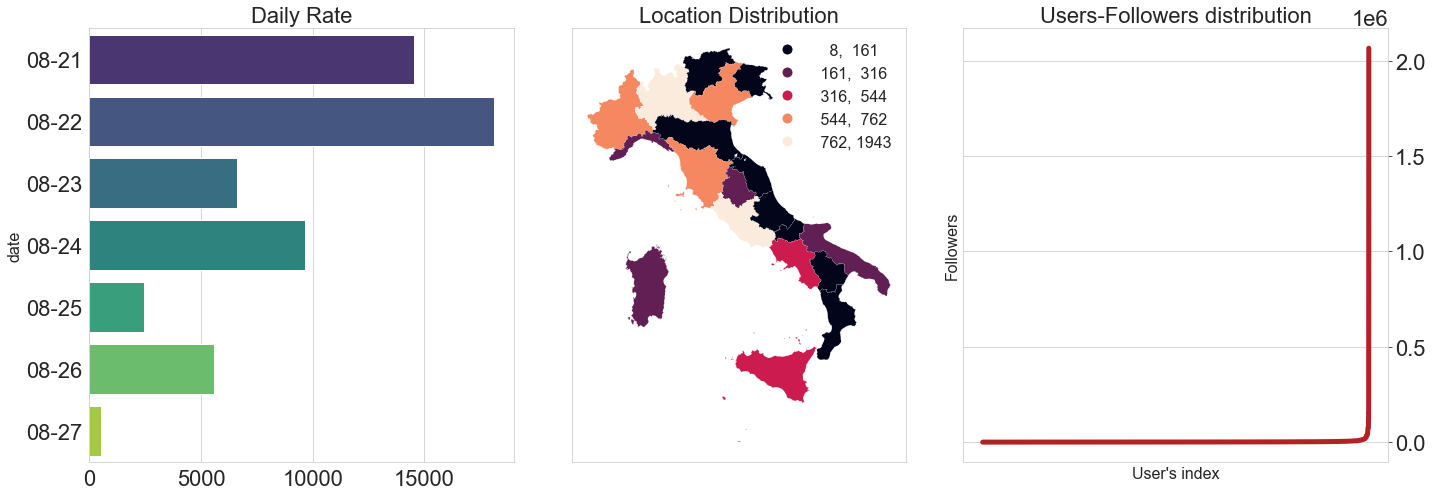

In [4]:
print(f"Tweets including retweets: {len(raw_tweet)}. Excluded: {len(tweet_unique)}")
nlp.plot_dates_location_followers(raw_tweet, save=True)

In [43]:
mining = TextMining()
just_text = tweet_unique.tweet_text.apply(lambda x: ' '.join(x))
vectorized_text = mining.vectorized_text(just_text.values.tolist())
features_name = mining.get_features_names()

filtered_words = mining.extract_topn_from_vector(features_name, mining.sort_coo(vectorized_text), 500)
filtered_words_set = set(filtered_words)

Shape of the Sparse Matrix (12396, 25127), type: <class 'scipy.sparse.csr.csr_matrix'>
Keywords founded: 462


In [44]:
tokenized_keywords = nlp.take_only_keywords_from_tweets(just_text, filtered_words_set, stem=False, min_len=2)

Remained docs: 623


In [45]:
vectorized_text = mining.vectorized_text([' '.join(x) for x in tokenized_keywords])

Shape of the Sparse Matrix (623, 215), type: <class 'scipy.sparse.csr.csr_matrix'>


In [46]:
degree_centrality = networkx.algorithms.centrality.degree_centrality(main_word_graph)
betweeneness_centrality = networkx.algorithms.centrality.betweenness_centrality(main_word_graph)
centrality = [degree_centrality, betweeneness_centrality]

In [47]:
top_percentage = 100
most_important_words = NetworkPlot.extract_top_centrality_words(centrality, top_percentage)

In [54]:
clusters = 3
main_word_graph_filterd_words = NetworkPlot.create_graph_from_top_centrality(main_word_graph, most_important_words)

main_word_graph_filterd_pairs = NetworkPlot.filter_pairwise_words(main_word_graph_filterd_words, 2)
NetworkPlot.keep_connected_components(main_word_graph_filterd_pairs, min_degree = 10)

cluster_label = NetworkPlot.spectral_clustering(main_word_graph_filterd_pairs, 4, k=15)
print((silhouette_score(networkx.to_numpy_matrix(main_word_graph_filterd_pairs), cluster_label)))

0.04688130619542099


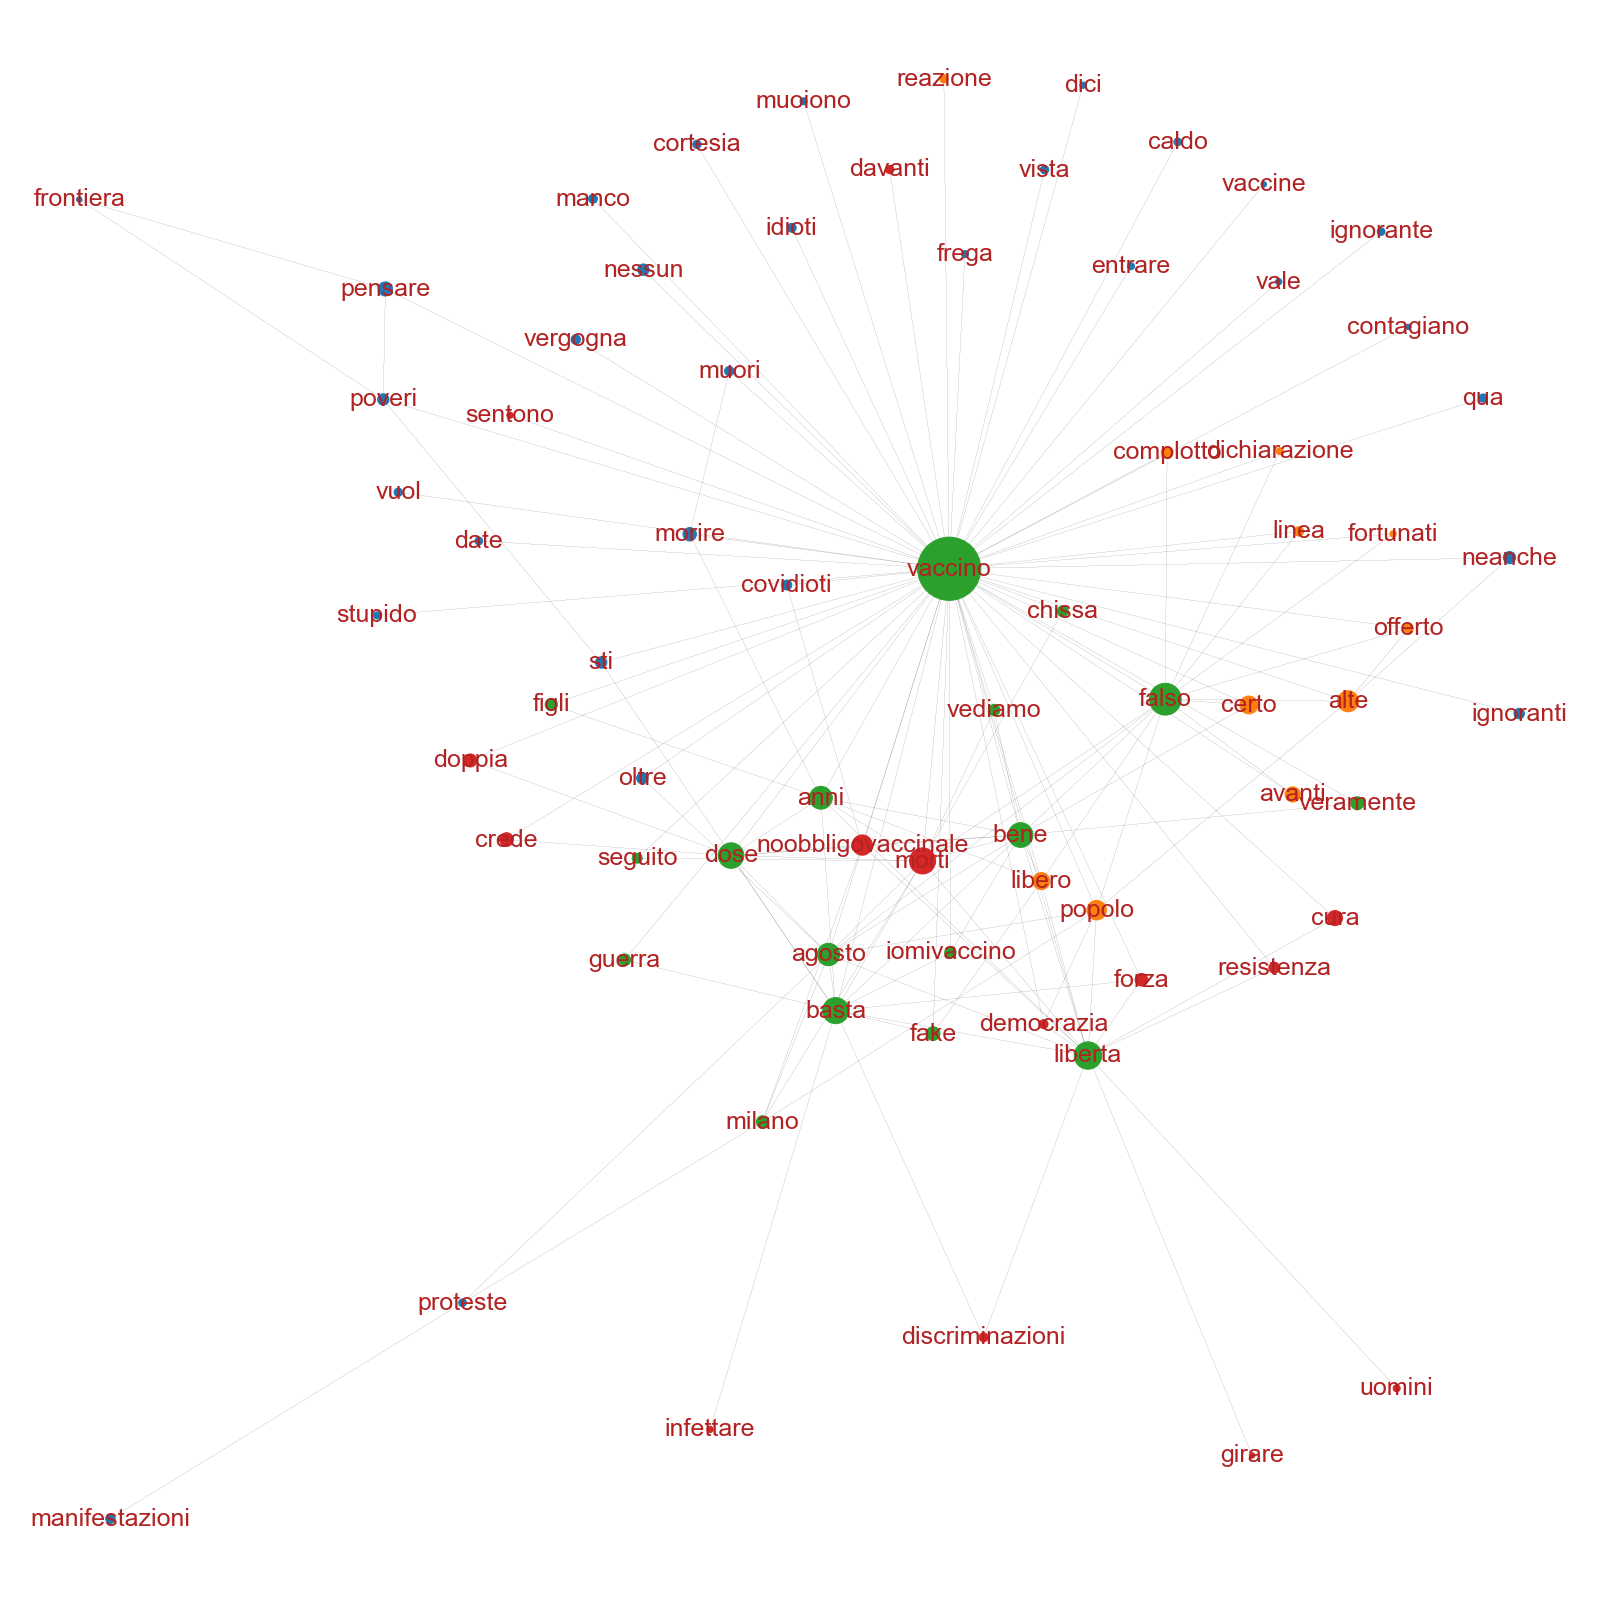

In [37]:
NetworkPlot(main_word_graph_filterd_pairs, freq_distrib_tweet, labels=cluster_label).plot_main_centrality(most_important_words, 10, save='graph')

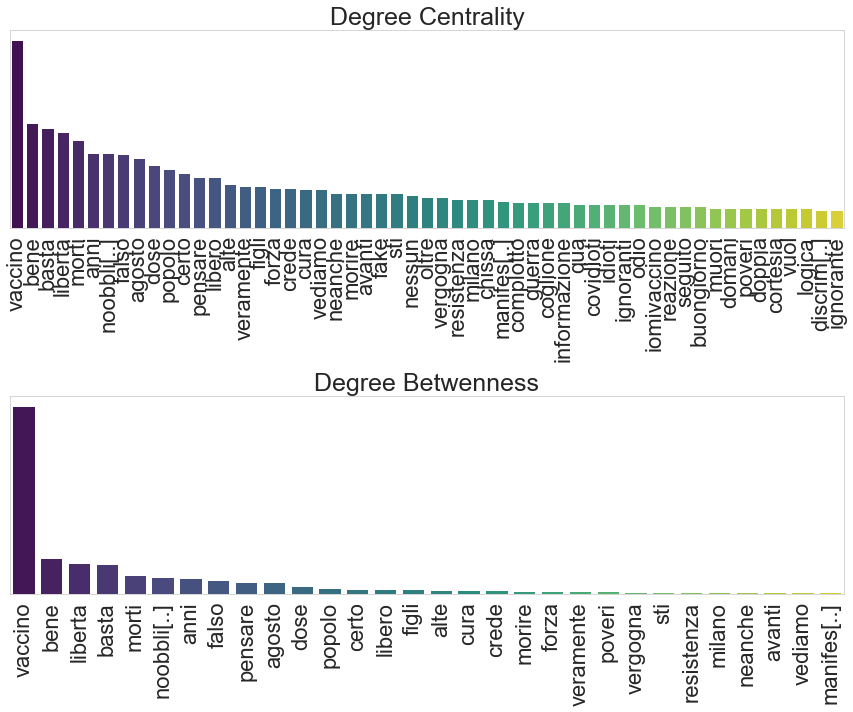

In [12]:
NetworkPlot.plot_centrality(centrality, save=True)

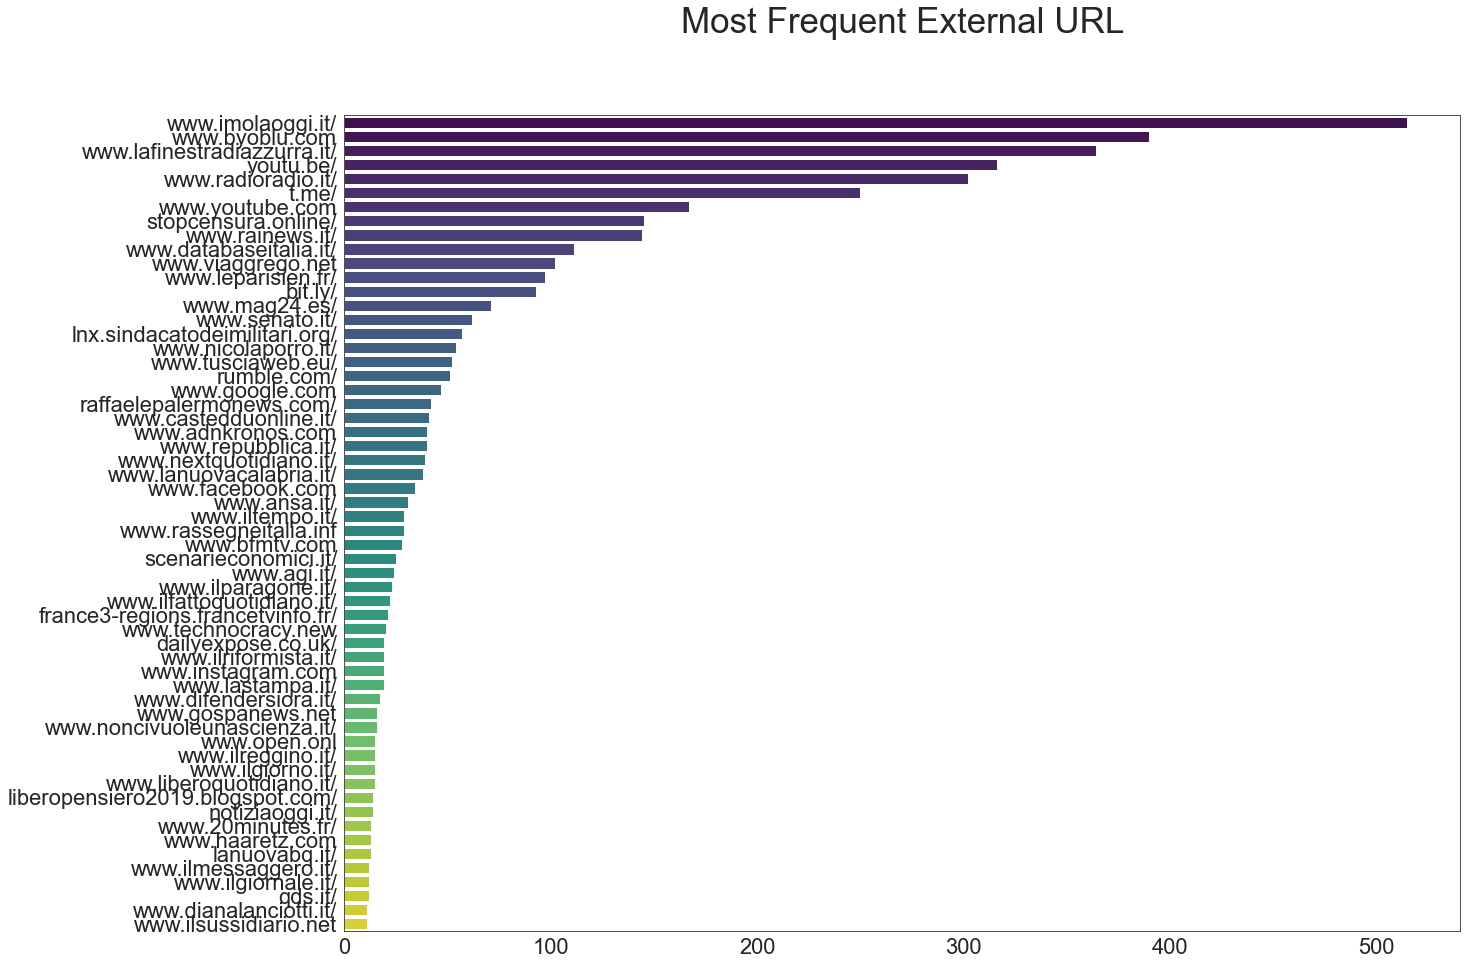

In [13]:
minium_thresold = 10
NetworkPlot.count_barplot(nlp.extract_external_url(raw_tweet), minium_thresold, save=True)

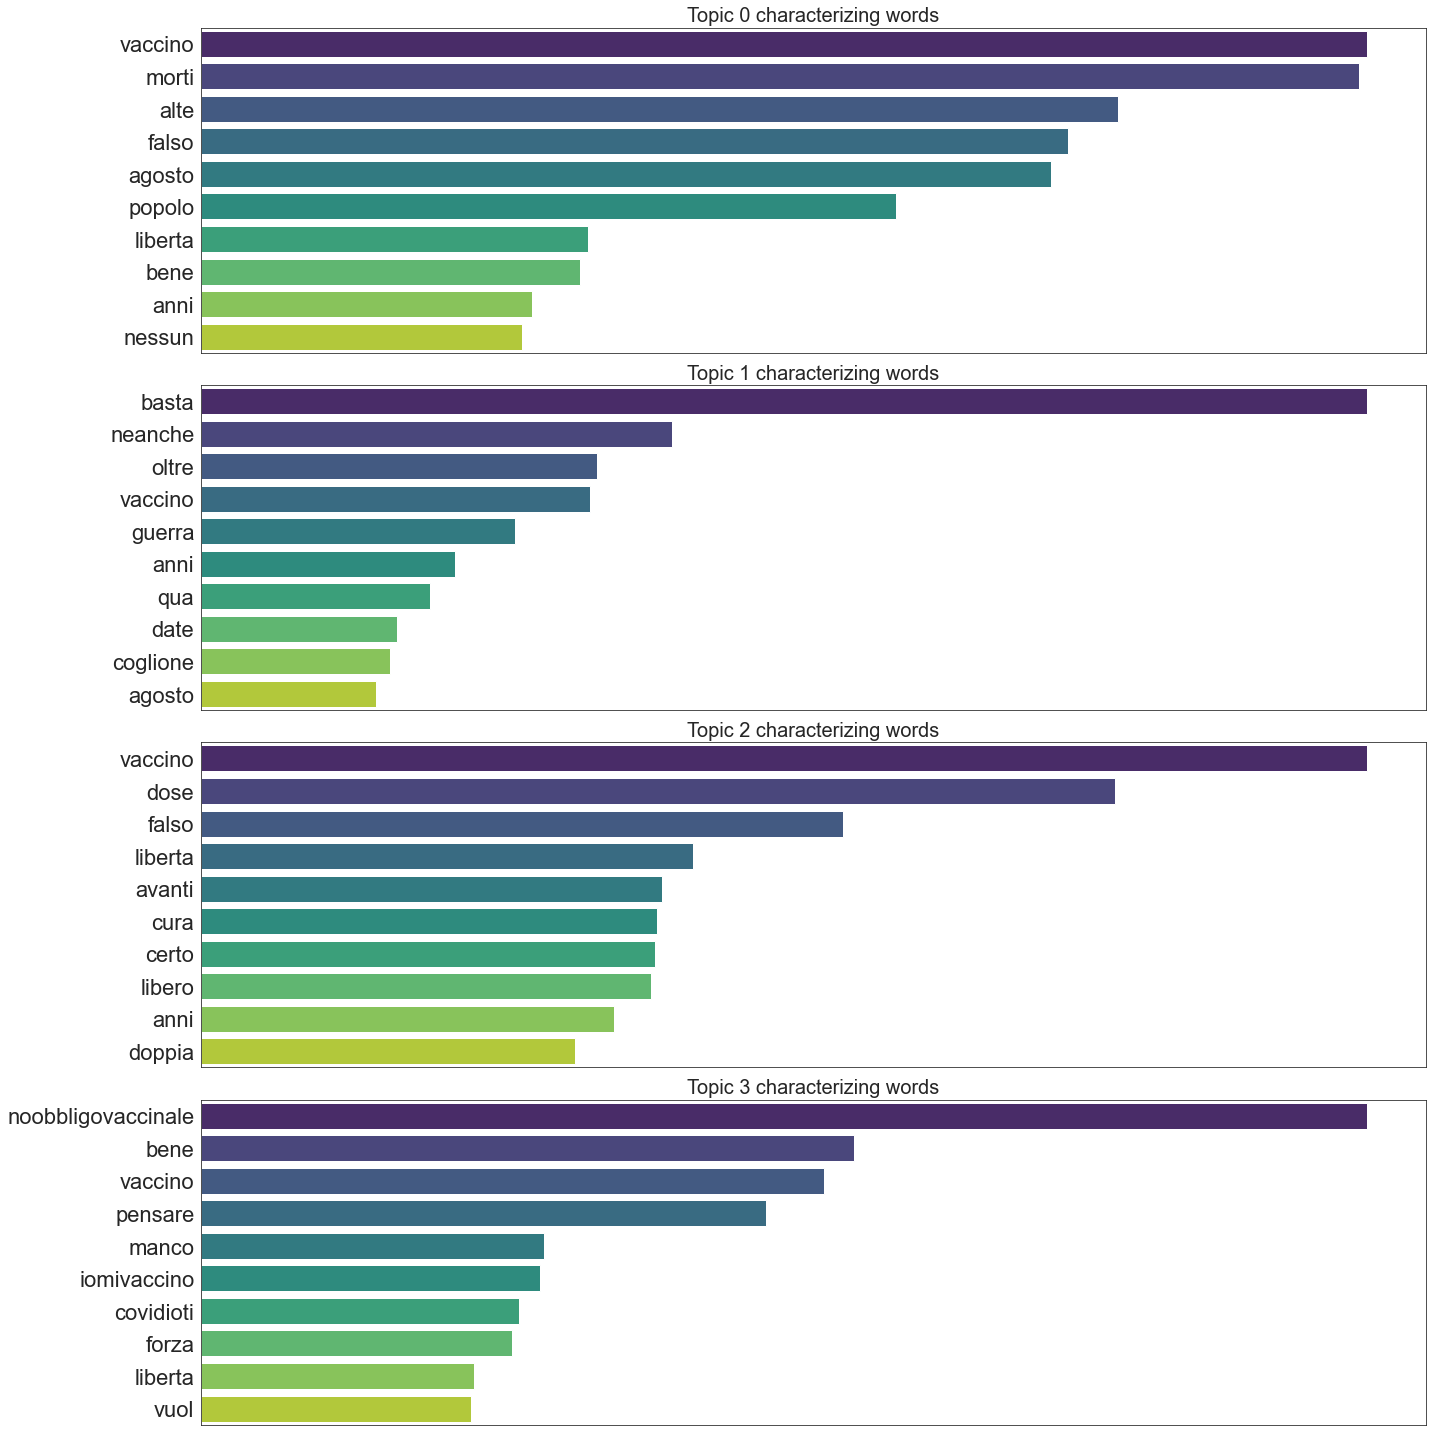

In [14]:
topics, top_word = 4, 10
lda_model = mining.lda_topic_modeling(vectorized_text, topics)
mining.plot_lda_topic(lda_model, topics, n_top_words=top_word, save=True)

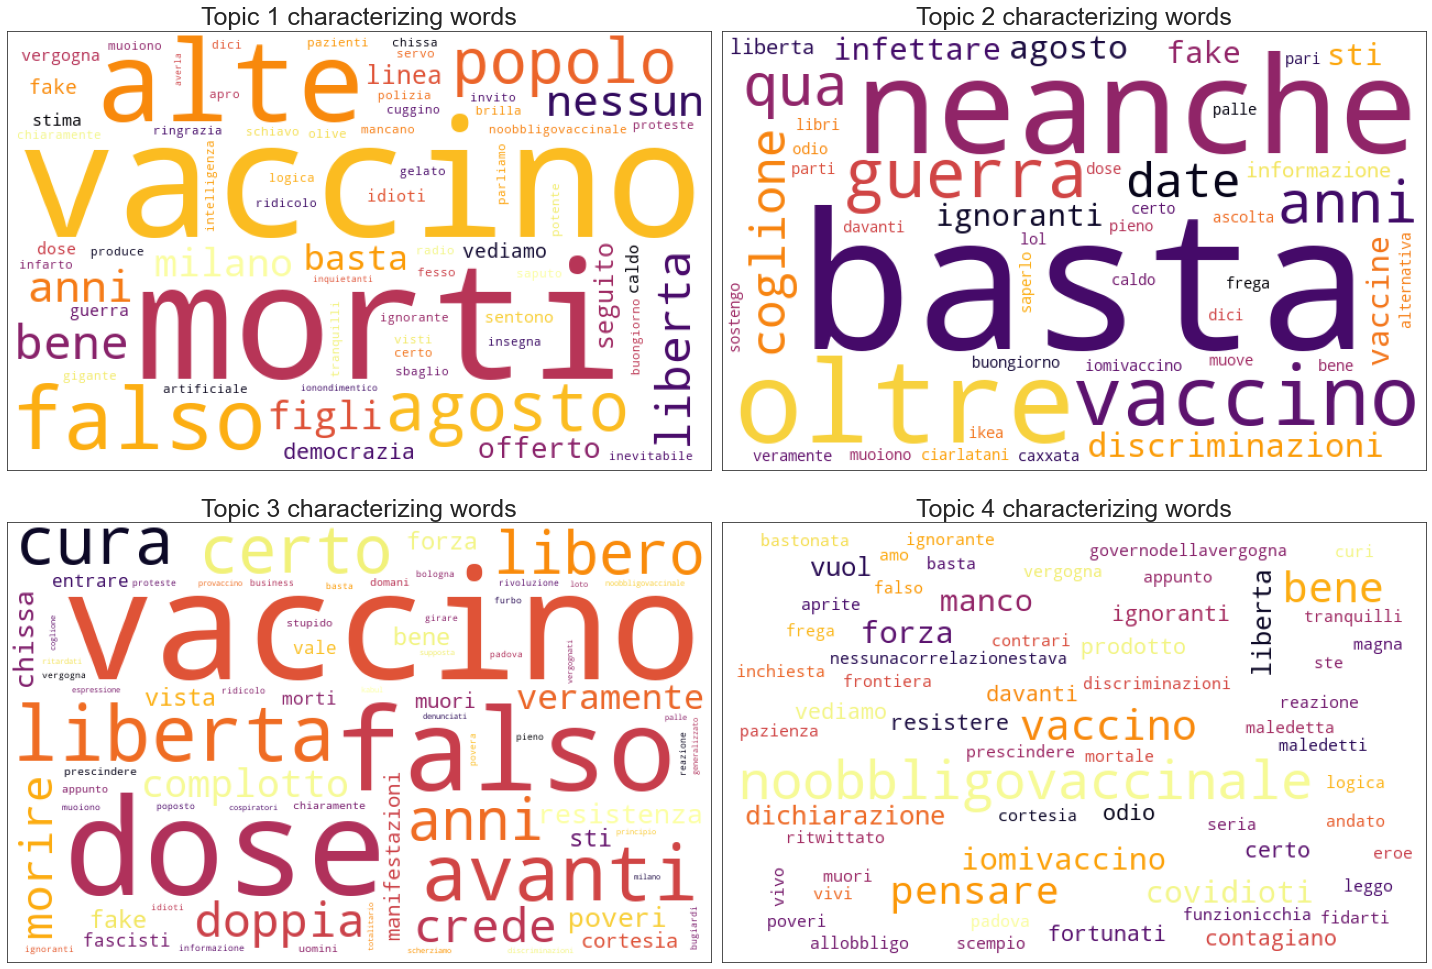

In [15]:
bag_of_words = mining.word_cloud_dict(lda_model)
mining.plot_wordcloud(bag_of_words, n_topics=4, save='lda-topics')

Explained variance of the SVD step: 0.49244455405670307%


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


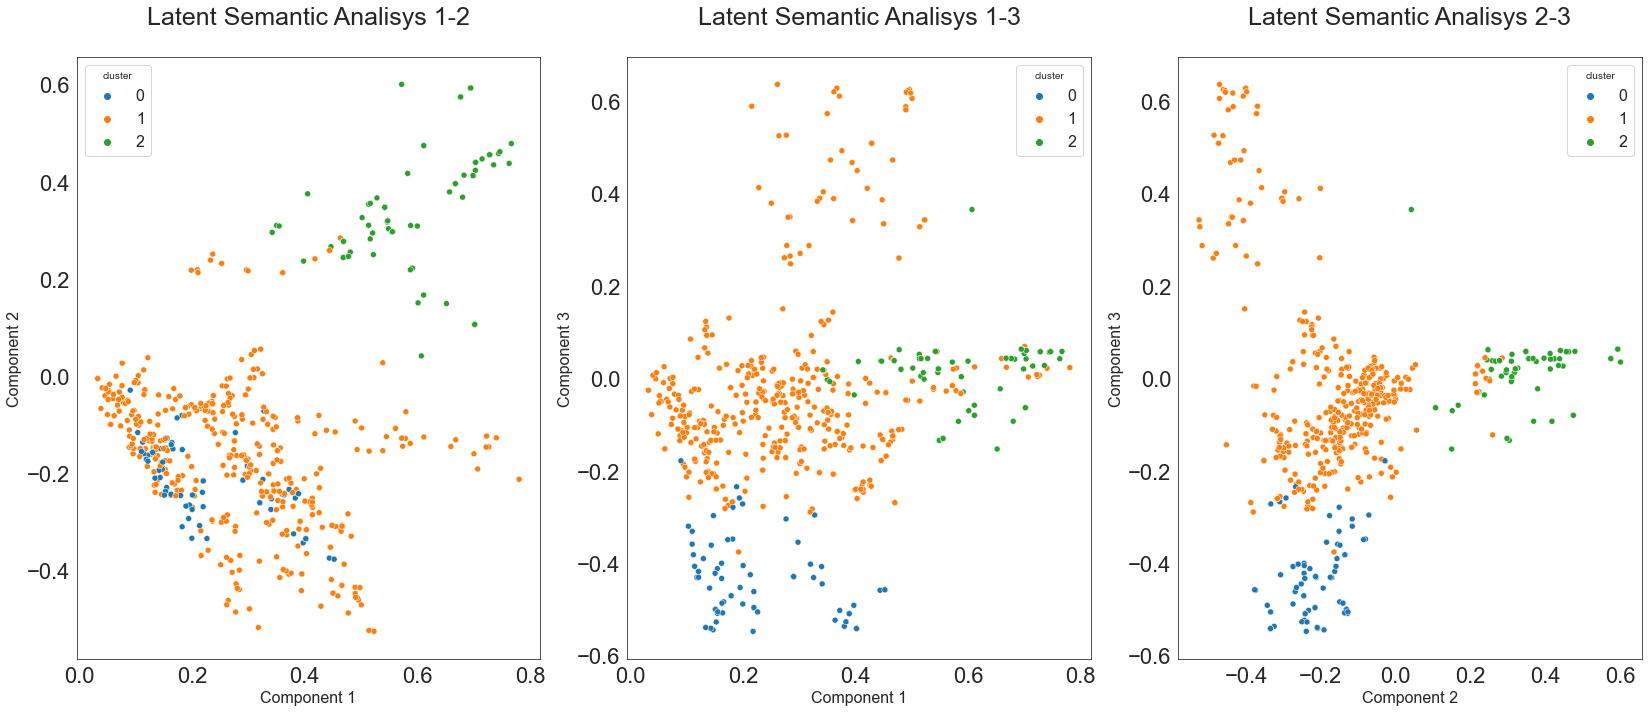

In [16]:
n_components = 25
svd_model, svd_result = mining.latent_semantic_analysis(vectorized_text, n_components) #networkx.to_numpy_matrix(graph)
kmeans = mining.clustering_kmeans(svd_result, 3)
mining.plot_lsa(svd_result, kmeans, n_components, save = True)

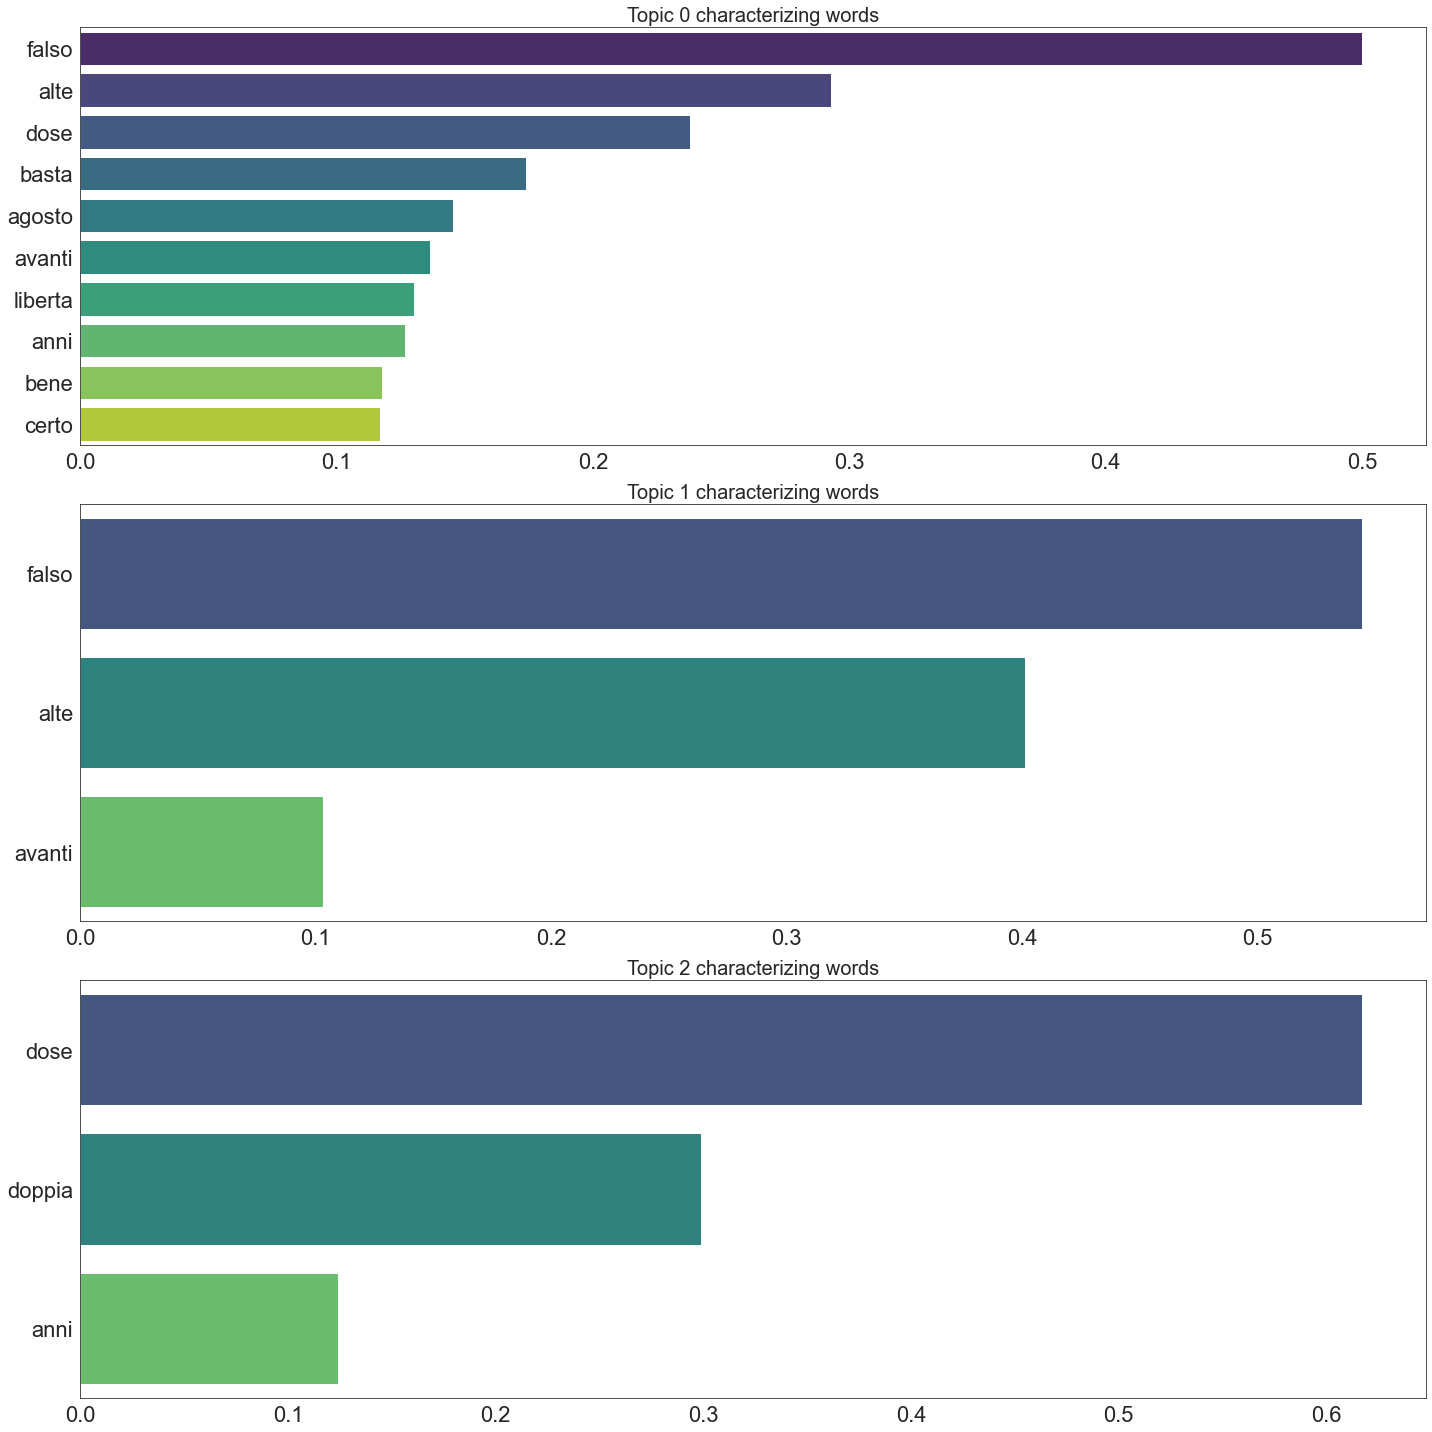

In [17]:
mining.plot_lsa_topic(svd_model, topics=3, top_word=10, save=True)

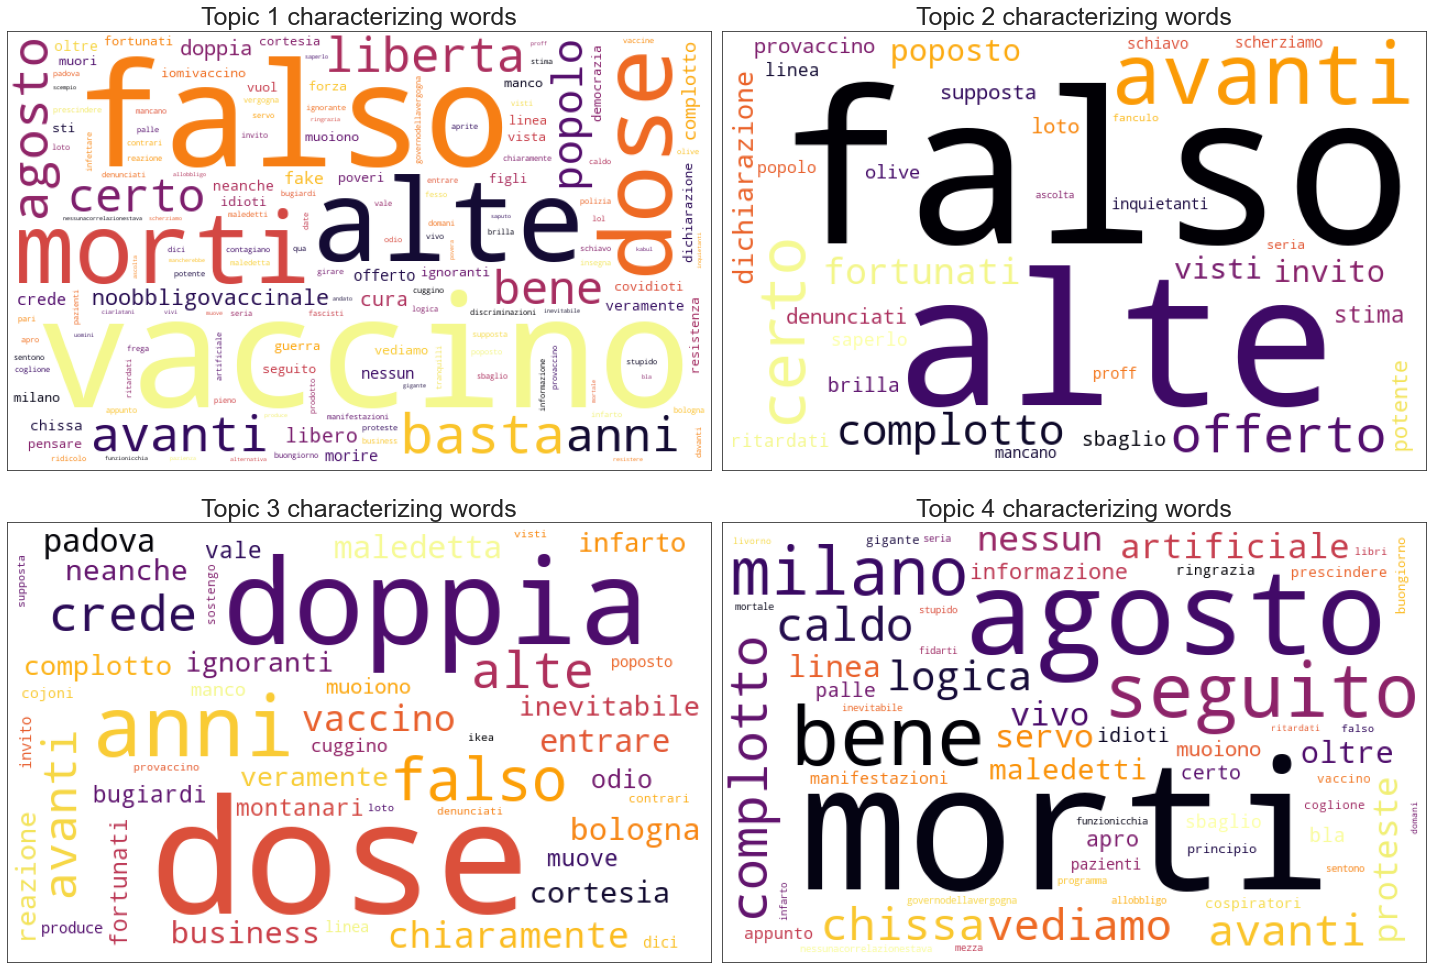

In [18]:
datas = mining.get_wordcloud_lsa(svd_model, topics=4)
mining.plot_wordcloud(datas, n_topics=4, save='lda-topics')

In [19]:
sparse_mat[0]

NameError: name 'sparse_mat' is not defined

In [ ]:
k = 20
sparse_mat = networkx.to_numpy_matrix(main_word_graph_filterd_pairs)
umap_reduced = pd.DataFrame(mining.umaps(sparse_mat, k=k), columns=[f'Component {i + 1}' for i in range(2)]) 
umap_reduced['labels'] = list(main_word_graph_filterd_pairs.nodes())

mining.plot_umaps(umap_reduced, n_cluster=4, k=k, palette='tab10', save='umap')

# HASHTAGS

freq_distrib_hash = nlp.frequency_dist(tweet_df, obj ='hash')
graph_hash = NetworkPlot.graph_filtered_dist(df=unique_tweet_df, distrib=freq_distrib_hash, thresold=600, obj='hash')
NetworkPlot.keep_connected_components(graph_tweet_filter, min_degree = 5)
NetworkPlot(graph=graph_hash, frequency_dist=freq_distrib_hash, label_thresold=50, color_thresold=100).plot()

mining = TextMining()
hash_to_vectorize = nlp.prepare_text_to_vectorize(unique_df, afil=True) # tweet_df
vectorized_hash = mining.vectorized_text(hash_to_vectorize)
print(f'Shape of the Sparse matrix: {vectorized_hash.shape}')

lda_model_hash, feature_names_hash = mining.lda_topic_modeling(vectorized_hash, 3)
mining.plot_lda_topic(lda_model_hash, 10)

n_components = 300
svd_result_hash = mining.latent_semantic_analysis(vectorized_hash, n_components)
kmeans = mining.clustering_kmeans(svd_result_hash, 3)
mining.plot_lsa(svd_result_hash, kmeans, n_components)

neighbours = [3,7,10,15]
umap_reduced_hash = [mining.umaps(vectorized_hash, k=i) for i in neighbours]
mining.plot_umaps(umap_reduced_hash, n_cluster=3, k=neighbours)

import geopandas as gpd
italy_path ="https://raw.githubusercontent.com/openpolis/geojson-italy/master/geojson/limits_IT_regions.geojson" #reg_name
italy = gpd.read_file(italy_path) # usual path
italy.loc[italy.reg_name == 'Trentino-Alto Adige/Südtirol', "reg_name"] = 'Trentino-Alto Adige'
with open('citta.json', 'r') as file:
    location = json.load(file)
region = inv_map = set(location.values())
punct = ['-','_','/',',','.','!','?']
flag,res = True, list()
for row in raw_tweet.author_loc.dropna():
    for p in punct:
        tmp = row.replace(p, ' ')
    for word in tmp.split(' '):
        if word in location:
            res.append(location[word])
            flag = False
    if flag:
        for word in tmp.split(' '):
            if word in region:
                res.append(word)
    flag = True
name, count = np.unique(res, return_counts=True)
loc = dict(zip(name, count))
loc = pd.DataFrame(loc, index=[0]).T.reset_index().rename(columns={'index': 'reg_name', 0: 'value'})
loc.loc[loc.reg_name == 'Trentino-Alto Adige/S�dtirol', ['reg_name']] = 'Trentino-Alto Adige'
merged = pd.merge(italy, loc, on='reg_name')
fig, axes= plt.subplots(figsize=(10,10))
merged.plot(ax=axes,
           column='value',
           linewidth = 0.1,
           scheme="NaturalBreaks", k=5,
           cmap = "cividis",
           aspect= 'auto',
           legend=True,      
           markersize=100,
           legend_kwds = dict(fmt = '{:.0f}', frameon=False, loc='lower left'))
plt.show()

clusters = 5
freq_distrib_tweet = nlp.frequency_dist(unique_tweet_df, obj ='tweet') #tweet_df or unique_df?
graph_tweet = NetworkPlot.graph_filtered_dist(unique_tweet_df, freq_distrib_tweet, 55)
graph_tweet_filter = NetworkPlot.filter_pairwise_words(graph_tweet, 10)
NetworkPlot.keep_connected_components(graph_tweet_filter, min_degree = 10)
cluster_label = NetworkPlot.spectral_clustering(graph_tweet_filter, clusters)
NetworkPlot(graph_tweet_filter, freq_distrib_tweet, label_thresold=50, labels=cluster_label).plot()
print(f"Averagle clustering of the network: {networkx.algorithms.cluster.average_clustering(graph_tweet_filter)}")

degree_centrality = networkx.algorithms.centrality.degree_centrality(graph_tweet_filter)
betweeneness_centrality = networkx.algorithms.centrality.betweenness_centrality(graph_tweet_filter)
closeness_centrality = networkx.algorithms.centrality.closeness_centrality(graph_tweet_filter)
NetworkPlot.plot_centrality([degree_centrality, betweeneness_centrality])

from sklearn.manifold import MDS
components=2
mds = MDS(random_state=42,
          n_components=components, 
          verbose=1)

mds_emb = mds.fit_transform(svd_result)
mds_df = pd.DataFrame(mds_emb, columns = [f'PC{i+1}' for i in range(components)])
mds_df.head(2)

# components = 10
# pca = PCA(n_components=components)
# pca_emb = pca.fit_transform(svd_result)
# pca_df = pd.DataFrame(pca_emb, columns = [f'PC{i+1}' for i in range(components)])
# explained_v(pca)

mds_df[(mds_df.PC1> 0.2) | (mds_df.PC2> 0.2) | (mds_df.PC1< -0.2) | (mds_df.PC2< -0.2)]

sns.scatterplot(data=mds_df[(mds_df.PC1> 0.2) | (mds_df.PC2> 0.2) | (mds_df.PC1< -0.2) | (mds_df.PC2< -0.2)], x='PC1', y='PC2')

main_word_graph = NetworkPlot.graph_filtered_dist(unique_tweet_df, freq_distrib_tweet, 15)
print(f'Number of nodes: {len(main_word_graph)}')

degree_centrality = networkx.algorithms.centrality.degree_centrality(main_word_graph)
print(f"Finish degree centrality at {time.datetime.now()}")
betweeneness_centrality = networkx.algorithms.centrality.betweenness_centrality(main_word_graph)
centrality = [degree_centrality, betweeneness_centrality]
print(f"Finish betweeness centrality at {time.datetime.now()}")

top_percentage = 2
most_important_words = NetworkPlot.extract_top_centrality_words(centrality, top_percentage)
print(f'Number of important words: {len(most_important_words)}')

clusters = 3
main_word_graph_filterd_words = NetworkPlot.create_graph_from_top_centrality(main_word_graph, most_important_words)
main_word_graph_filterd_pairs = NetworkPlot.filter_pairwise_words(main_word_graph_filterd_words, 5)
NetworkPlot.keep_connected_components(main_word_graph_filterd_pairs, min_degree = 10)

cluster_label = NetworkPlot.spectral_clustering(main_word_graph_filterd_pairs, clusters, k=100)
NetworkPlot(main_word_graph_filterd_pairs, freq_distrib_tweet, labels=cluster_label).plot_main_centrality(most_important_words)

print(f"Averagle clustering of the network: {networkx.algorithms.cluster.average_clustering(main_word_graph)}")
NetworkPlot.plot_centrality([degree_centrality, betweeneness_centrality])

minium_thresold = 10
NetworkPlot.count_barplot(nlp.extract_external_url(raw_tweet), minium_thresold)


mining = TextMining()
text_to_vectorize = nlp.prepare_text_to_vectorize(unique_tweet_df, afil=True) # tweet_df
vectorized_text = mining.vectorized_text(text_to_vectorize)
print(f'Shape of the Sparse matrix: {vectorized_text.shape}')

In [ ]:
f"dasdjs{True}"